<a href="https://colab.research.google.com/github/ppiont/tensor-flow-state/blob/master/Model_training_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TRY:
 - More units in dense layer(s) (*)
 - Dropout to 0.2/0.5 instead (*)
 - Bidirectional LSTM (*)
 - Add density feature (*)
 - Add weather (*)
 - Min-max scale instead of log transform (*)
 - Learning rate scheduling (and/or stop-resume)
 - TimeDistributed (Conv1D)
 - Smoothing (*)

In [0]:
from google.colab import drive
drive.mount("/gdrive", force_remount = True)

Mounted at /gdrive


In [0]:
%cd "/gdrive/My Drive/tensor-flow-state/tensor-flow-state"

/gdrive/My Drive/tensor-flow-state/tensor-flow-state


In [0]:
import pandas as pd
df = pd.read_csv("data/final_data.csv", index_col = 0, parse_dates = True)

In [0]:
df = df[df.index > "2016-06-02"]
df['density'] = (df.flow * 60) / df.speed

In [0]:
cols = ["speed", "flow", "density", "speed_-2", "speed_-1","speed_+1", "speed_+2", "flow_-2", "flow_-1", "flow_+1", "flow_+2", "temp", "dew_point_temp", "precip_duration", "precip_sum", "sun_duration", "sun_radiation", "speed_limit", "holiday", "weekend"]
speed_cols = ["speed", "speed_-2", "speed_-1","speed_+1", "speed_+2"]
flow_cols = ["flow", "flow_-2", "flow_-1", "flow_+1", "flow_+2"]

df = df[cols]

### First resample to elmininate some noise

In [0]:
import numpy as np
def resample_df(df, freq = "15T", method_speed = np.mean, method_flow = np.sum):
    r_df = df.copy()
    r_df = r_df.resample(freq).agg({
           "speed": method_speed, "speed_-2": method_speed, "speed_-1": method_speed, "speed_+1": method_speed, "speed_+2": method_speed,
           "flow": method_flow, "flow_-2": method_flow, "flow_-1": method_flow, "flow_+1": method_flow, "flow_+2": method_flow,
           "density": np.mean, "speed_limit": np.median, "holiday": np.median, "weekend": np.median,
           "dew_point_temp": np.mean, "precip_duration": np.mean, "precip_sum": np.mean, "sun_duration": np.mean, "sun_radiation": np.mean})
    return r_df

In [0]:
r_df = resample_df(df, freq = "15T")

### Rolling mean

In [0]:
r_df_smoothed = r_df.copy()
for col in speed_cols:
    r_df_smoothed[col] = r_df_smoothed[col].rolling(3, min_periods=1).mean()

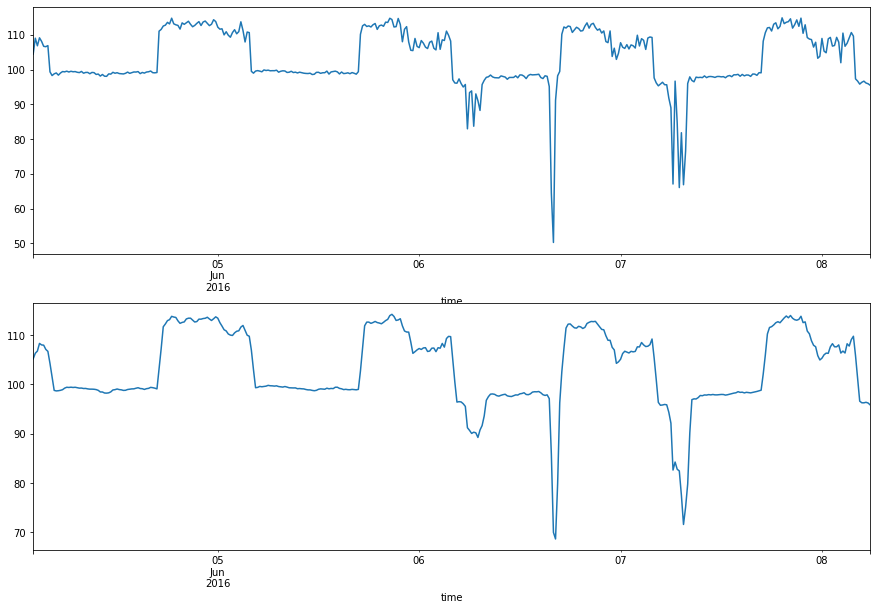

In [0]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 10))
# r_df[200:600]['speed'].plot(ax = ax[0])
# r_df_smoothed[200:600]['speed'].plot(ax = ax[1])

### Train test split. The final year is reserved for testing. (Val will be relevant later?)

In [0]:
def train_split(split_df):
    train = split_df[split_df.index.year < 2019].copy()
    val = split_df[len(train): -len(split_df[split_df.index > "2019-06"]) - 1].copy()
    test = r_df[len(train) + len(val):].copy()
    return train, val, test

train, val, test = train_split(r_df_smoothed)

### Log transform

In [0]:
# import numpy as np
# def log_transform(df):
#     copy = df.copy()
#     return np.log(copy.iloc[:, :-3].replace(0, 1e-15)).join(df.iloc[:, -3:], how = 'inner')

# # Log transform. First set 0s to very low value 'cause you can't log 0.
# train_log = log_transform(train)
# val_log = log_transform(val)
# test_log = log_transform(test)

In [0]:
# X_train = np.array(train_log)
# y_train = np.array(train_log.speed)
# X_val = np.array(val_log)
# y_val = np.array(val_log.speed)
# X_test = np.array(test_log)
# y_test = np.array(test_log.speed)

### MinMax Scaling

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
X_train = scaler.transform(train)
y_train = X_train[:, 0]
X_val = scaler.transform(val)
y_val = X_val[:, 0]
X_test = scaler.transform(test)
y_test = X_test[:, 0]

In [0]:
%tensorflow_version 2.x
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

lookback = int(24 * (60 / 15))
batch_size = 128

train_gen = TimeseriesGenerator(data = X_train, targets = y_train, length = lookback, batch_size = batch_size)
val_gen = TimeseriesGenerator(data = X_val, targets = y_val, length = lookback, batch_size = batch_size)
test_gen = TimeseriesGenerator(data = X_test, targets = y_test, length = lookback, batch_size = batch_size)
 
#explore_generator = TimeseriesGenerator(X_train, y_train.shift(-forecast+1).values)

In [0]:
# ML
import tensorflow as tf
import pdb
import matplotlib.pyplot as plt
import datetime, os
#%load_ext tensorboard

  ...
    to  
  ['...']
Train for 707 steps, validate for 113 steps
Epoch 1/50
707/707 [==============================] - 405s 573ms/step - loss: 0.1471 - val_loss: 0.0104
Epoch 2/50
707/707 [==============================] - 397s 562ms/step - loss: 0.0079 - val_loss: 0.0068
Epoch 3/50
707/707 [==============================] - 419s 592ms/step - loss: 0.0049 - val_loss: 0.0053
Epoch 4/50
707/707 [==============================] - 395s 559ms/step - loss: 0.0036 - val_loss: 0.0048
Epoch 5/50
707/707 [==============================] - 392s 554ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 6/50
707/707 [==============================] - 389s 550ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 7/50
707/707 [==============================] - 392s 554ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 8/50
707/707 [==============================] - 412s 583ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 9/50
707/707 [==============================] - 396s 559ms/step - loss: 0.0020 - val_loss: 0.

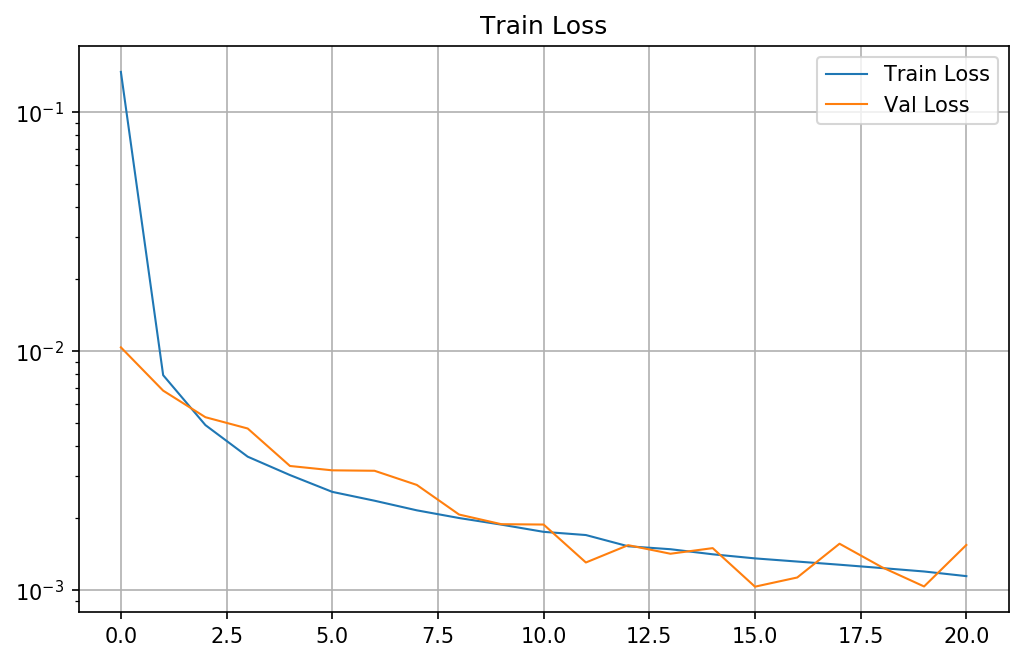

In [0]:
############## Define Neural Network Class ##############
class neural_net(tf.keras.Model):
    def __init__(self, lookback = 24 * 4, regularization = 1e-6): # You can choose to have more input here! E.g. number of neurons.
        super(neural_net, self).__init__()

        # Define l2 regularization
        self.regularization = regularization
        regu = tf.keras.regularizers.l2(self.regularization)

        # Define lookback
        self.lookback = lookback

        # Define discrete feature layers
        self.discrete_flatten = tf.keras.layers.Flatten()
        self.discrete_prelu1 = tf.keras.layers.PReLU()
        self.discrete_bnorm1 = tf.keras.layers.BatchNormalization()
        self.discrete_dense1 = tf.keras.layers.Dense(64, activation = 'linear', use_bias = True, kernel_regularizer =  regu)
        self.discrete_prelu2 = tf.keras.layers.PReLU()

        # Define time feature layers
        # Time 1
        self.time1_conv1 = tf.keras.layers.Conv1D(filters = 64, kernel_size = (1), use_bias = True, kernel_regularizer = regu)
        self.time1_prelu1 = tf.keras.layers.PReLU()
        self.time1_lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 32, dropout = 0.5, recurrent_dropout = 0.5, input_shape = (self.lookback, 64), kernel_regularizer = regu))
        self.time1_prelu2 = tf.keras.layers.PReLU()

        # Time 2
        self.time2_conv1 = tf.keras.layers.Conv1D(filters = 64, kernel_size = (1), use_bias = True, kernel_regularizer = regu)
        self.time2_prelu1 = tf.keras.layers.PReLU()
        self.time2_lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 32, dropout = 0.5, recurrent_dropout = 0.5, input_shape = (self.lookback, 64), kernel_regularizer = regu))
        self.time2_prelu2 = tf.keras.layers.PReLU()

        # Define Merged layers
        self.bnorm1 = tf.keras.layers.BatchNormalization()
        self.dense1 = tf.keras.layers.Dense(32, use_bias = True, kernel_regularizer = regu)
        self.prelu1 = tf.keras.layers.PReLU()
        self.bnorm2 = tf.keras.layers.BatchNormalization()
        self.dense2 = tf.keras.layers.Dense(1, activation = 'linear', use_bias = True, kernel_regularizer = regu)

    # Define the forward propagation
    def call(self, inputs):
        
        # Split time and discrete inputs
        x_time = inputs[:, :, :-3]
        x_discrete = inputs[:, :, -3:]

        # Run discrete layers
        x_discrete = self.discrete_flatten(x_discrete)
        x_discrete = self.discrete_prelu1(x_discrete)
        #x_discrete = self.discrete_bnorm1(x_discrete)
        x_discrete = self.discrete_dense1(x_discrete)
        x_discrete = self.discrete_prelu2(x_discrete)

        # Run time layers
        x_time1 = self.time1_conv1(x_time)
        x_time1 = self.time1_prelu1(x_time1)
        x_time1 = self.time1_lstm1(x_time1)
        x_time1 = self.time1_prelu2(x_time1)
        
        x_time2 = self.time2_conv1(x_time)
        x_time2 = self.time2_prelu1(x_time2)
        x_time2 = self.time2_lstm1(x_time2)
        x_time2 = self.time2_prelu2(x_time2)

        # Concat layers
        x = tf.concat([x_time1, x_time2, x_discrete], axis = 1)
        x = self.bnorm1(x)
        x = self.dense1(x)
        x = self.prelu1(x)
        x = self.bnorm2(x)
        x = self.dense2(x)
        
        # Return output
        return x

# Create an instance of you neural network model
model = neural_net(lookback = lookback, regularization = 1e-6)

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

# Define loss function
mse_loss_fn = tf.keras.losses.MeanSquaredError()

# Compile model
model.compile(optimizer = optimizer, loss = mse_loss_fn)

# Define callback
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 0)
#%tensorboard --logdir logs

# Train model
history = model.fit(train_gen, validation_data = val_gen, epochs = 50, callbacks = [callback]) #, tensorboard_callback])
train_loss, val_loss = history.history['loss'], history.history['val_loss']

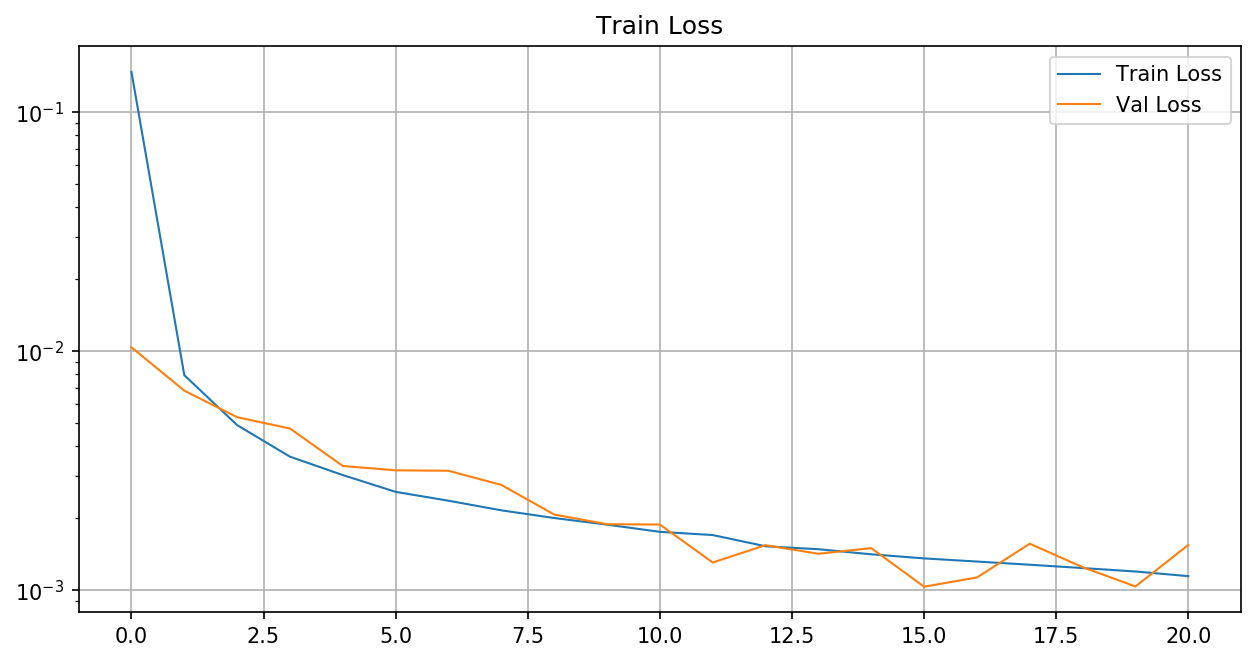

In [0]:
# Plot test and validation loss
mpl.rcParams["figure.dpi"] = 150
plt.rcParams["figure.figsize"] = (10, 5)
plt.figure()
plt.semilogy(train_loss, lw = 1)
plt.semilogy(val_loss, lw = 1)
plt.legend(['Train Loss', 'Val Loss'])
plt.grid(True)
plt.title('Train Loss')
plt.show()

In [0]:
val_pred = model.predict(val_gen)

In [0]:
# predictions = pd.DataFrame(data = np.exp(val_log.iloc[lookback:, 0].values), index = val_log[lookback:].index, columns = ['True speed'])
# predictions["Predicted speed"] = np.exp(val_pred)
# predictions["Speed limit"] =  np.where(val.iloc[lookback:, val.columns.get_loc('speed_limit')] > 0.5, 130, 100)

In [0]:
predictions = pd.DataFrame(data = r_df.iloc[len(train) + lookback : -len(r_df[r_df.index > "2019-06"]) - 1, 0].values, index = val[lookback:].index, columns = ['True speed'])
# predictions = pd.DataFrame(data = val.iloc[lookback:, 0].values, index = val[lookback:].index, columns = ['True speed'])
fudge = val.copy()
fudge.iloc[lookback:, 0] = val_pred
predictions["Predicted speed"] = scaler.inverse_transform(fudge)[lookback:, 0]
predictions["Speed limit"] =  np.where(val.iloc[lookback:, val.columns.get_loc('speed_limit')] > 0.5, 130, 100)

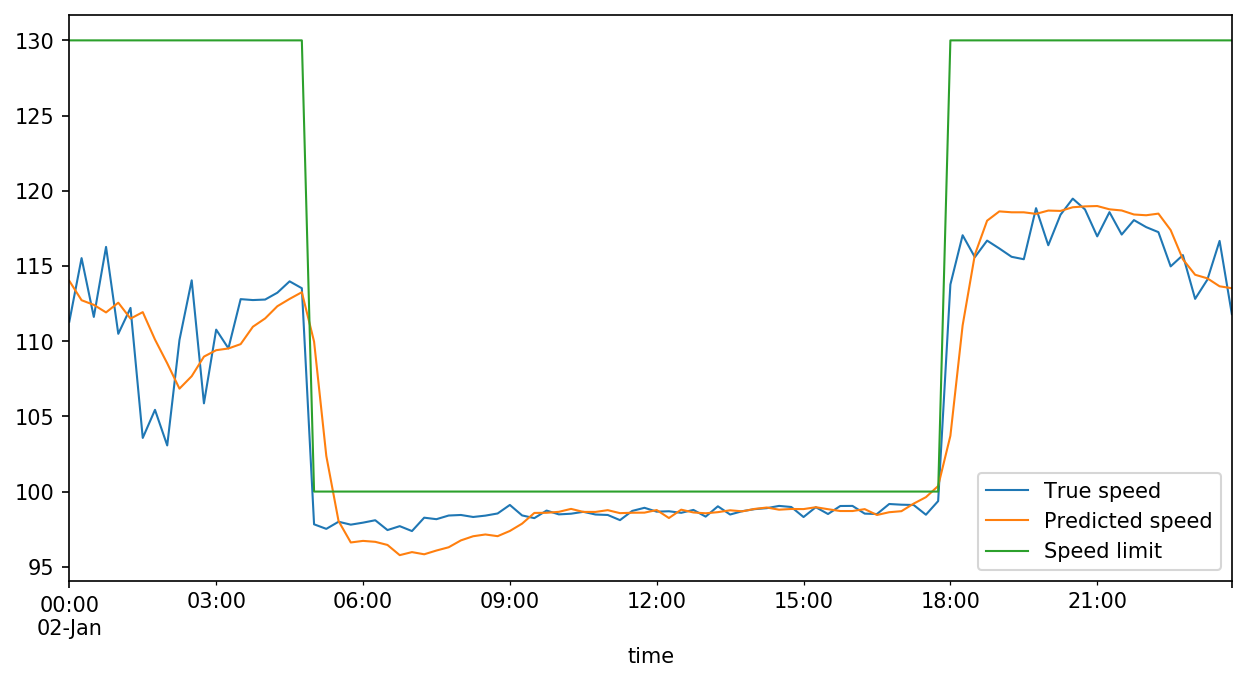

In [0]:
import matplotlib as mpl
predictions[:96].plot(figsize = (10, 5), lw = 1)

In [0]:
print(f"Model R^2: {np.mean((predictions['True speed'] - predictions['Predicted speed'])**2)}")
speed = predictions['True speed'].values
print(f"Naive R^2: {np.mean((speed[1:] - speed[:-1])**2)}")

Model R^2: 25.972397338038355
Naive R^2: 24.448094035079595


In [0]:
#Evaluate on test set
test_loss = model.evaluate(test_gen)
print('Test Loss: ' + str(test_loss))